In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math
from scipy import stats
from sklearn.metrics import mean_absolute_error
from adjustText import adjust_text

### A model to predict alpha based on exposure to developmental stages?

Load data

In [2]:
# Read DNM data
dnm = pd.read_csv("../data/dnm_est.tsv",sep="\t")
dnm["alpha_dnm"] = dnm["Pat DNMs"]/dnm["Mat DNMs"]
dnm["species"] = ["_".join(sp.split()[:2]) for sp in dnm.Species]

# Read traits database
traits = pd.read_csv("../data/zoonomia_assembly_metadata.csv")

# Read substitution rates
subrates = pd.read_csv("../data/subrate_div_data.txt",sep="\t")
subrates = subrates[subrates.Subset=="Mammals"]
subrates = subrates[["Species","DivTime","MutPerYearUCSC"]]

# Read alpha from XA
xa_alpha = pd.read_csv("../scripts/alphas/Mammals.Homo_sapiens.LM.tsv",sep="\t")#_ultrathinned
xa_alpha = xa_alpha[(xa_alpha.mut_type=="mod")].reset_index()

# Merge generation time, subsitution rates and XA alphas
complete_data = xa_alpha.set_index("species").join(subrates.set_index("Species")).join(traits.set_index("Species")).reset_index()

In [3]:
# Fill generation times that are known but missing in the database

fill_gen_t = {"Bos_taurus": 6*365,
              "Canis_lupus_familiaris": 3.5*365,
              "Ceratotherium_simum_cottoni":13*365,
              "Nomascus_leucogenys":13.5*365,
              "Equus_caballus":12*365,
              "Felis_catus": 2.25*365,
              "Homo_sapiens":29*365,
              "Ovis_aries":5.1*365,
              "Callithrix_jacchus": 2.5*365,
              "Dicerorhinus_sumatrensis":12*365,
              "Macaca_mulatta":7.5*365,
              "Microcebus_murinus":3.125*365,
              "Mus_musculus":0.75*365,
              "Mus_pahari":0.75*365,
              "Rattus_norvegicus":1*365,
              "Oryctolagus_cuniculus":1.8*365,
              "Saimiri_boliviensis":4.5*365,
              "Sus_scrofa":2.5*365,
              "Pongo_abelii":25*365,
              "Daubentonia_madagascariensis":8*365,
             }

filled_gen_t = []

complete_data["GenerationLength_d"] = [fill_gen_t[r.species] for i,r in complete_data.iterrows()]

The model

In [4]:
def identity_line(ax=None, ls='--', *args, **kwargs):
    ax = ax or plt.gca()
    identity, = ax.plot([], [], ls=ls, *args, **kwargs)
    def callback(axes):
        low_x, high_x = ax.get_xlim()
        low_y, high_y = ax.get_ylim()
        low = min(low_x, low_y)
        high = max(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(ax)
    ax.callbacks.connect('xlim_changed', callback)
    ax.callbacks.connect('ylim_changed', callback)
    return ax

def ratioG(G_a, ratio):
    G_f = (2*G_a)/(1+ratio)
    return G_f,G_f*ratio

def muy_to_mufm(mu_y, G_f, G_m, mu_e, alpha):
    n = (mu_y*(G_f + G_m))-(2*mu_e)
    d = G_f + alpha*G_m
    mu_f = n/d
    mu_m = alpha*mu_f
    return mu_f, mu_m

def model(mu_y, G_a, ratios, mu_e, alpha, species, hue):

    alphas_r = []
    
    for r in ratios:
        G_f, G_m = ratioG(G_a,r)
        mu_f, mu_m = muy_to_mufm(mu_y, G_f, G_m, mu_e, alpha)
        male = mu_m*G_m + mu_e
        female = mu_f*G_f + mu_e
        alphas_r.append(male/female)
        
    return pd.Series([mu_e,mu_e,mu_e,species,alphas_r[0], alphas_r[1], alphas_r[2], hue])

In [6]:
species2common = {'Bos_taurus': 'Cattle',
                  'Callithrix_jacchus': 'Marmoset',
                  'Canis_lupus_familiaris': 'Dog',
                  'Ceratotherium_simum_cottoni': 'Southern rhino',
                  'Dicerorhinus_sumatrensis': 'Sumatran rhino',
                  'Equus_caballus': 'Horse',
                  'Felis_catus': 'Cat',
                  'Homo_sapiens': 'Human',
                  'Macaca_mulatta': 'Macaque',
                  'Microcebus_murinus': 'Mouse lemur',
                  'Mus_musculus': 'Mouse',
                  'Mus_pahari': 'Shrew mouse',
                  'Nomascus_leucogenys': 'Gibbon',
                  'Oryctolagus_cuniculus': 'Rabbit',
                  'Pongo_abelii': 'Orangutan',
                  'Rattus_norvegicus': 'Rat',
                  'Saimiri_boliviensis': 'Squirrel monkey',
                  'Sus_scrofa': 'Pig',
                  "Daubentonia_madagascariensis":"Aye aye",
                  "Ovis_aries":"Sheep",
                 }

In [13]:
# Predict
E = 4.5/3e9
subd = complete_data[(~complete_data.GenerationLength_d.isna()) &
                     (~complete_data.MutPerYearUCSC.isna()) 
                     #(complete_data.species.isin(["Bos_taurus","Equus_caballus","Ceratotherium_simum_cottoni","Dicerorhinus_sumatrensis","Ovis_aries"]))
                     #(complete_data.species.isin(["Callithrix_jacchus","Homo_sapiens","Daubentonia_madagascariensis","Pongo_abelii","Saimiri_boliviensis","Nomascus_leucogenys","Macaca_mulatta","Microcebus_murinus"]))
                     #& (~complete_data.species.isin(["Felis_catus","Canis_lupus_familiaris"]))
                    ]
predicted_alphas = subd.apply(lambda row: model(mu_e = E,   
                                                G_a = row.GenerationLength_d/365, 
                                                ratios = [0.7, 1, 1.3],
                                                mu_y = row.MutPerYearUCSC/1e6, 
                                                species = row.species,
                                                hue = "Mammals",
                                                alpha = 4,
                                               ), axis=1
                             )
predicted_alphas.columns = ["E","P","Efrac","species","predicted_alpha_lwr", "predicted_alpha", "predicted_alpha_upr", "experiment"]
predicted_alphas["alpha"] = subd.alpha
predicted_alphas["max_alpha"] = subd.alpha_upr
predicted_alphas["min_alpha"] = subd.alpha_lwr
color_labels = predicted_alphas['experiment'].unique()

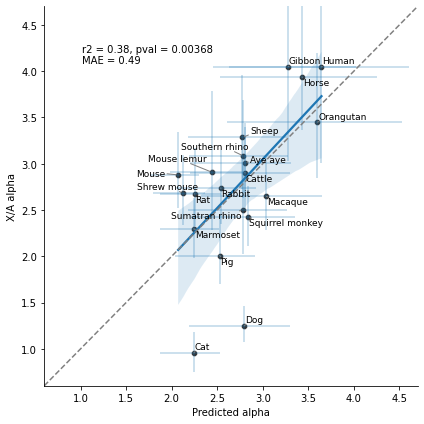

In [15]:
f,ax = plt.subplots(figsize=[6,6])
r1,pval = stats.pearsonr(predicted_alphas.predicted_alpha, predicted_alphas.alpha)
r2 = r1**2
mae = mean_absolute_error(predicted_alphas.predicted_alpha, predicted_alphas.alpha)
sns.scatterplot(data=predicted_alphas, x="predicted_alpha",y="alpha",ax=ax,legend=False, color="black", alpha=0.8)#, hue="experiment", hue_order=color_labels)#
sns.regplot(data = predicted_alphas, x="predicted_alpha", y="alpha", ax=ax, scatter=False)

rgb_values = sns.color_palette("Set1", 8)
color_map = dict(zip(color_labels, rgb_values))
ax.hlines(xmin=predicted_alphas.predicted_alpha_lwr, xmax=predicted_alphas.predicted_alpha_upr, y=predicted_alphas.alpha, linewidth=1.5, alpha=0.3)#, color=predicted_alphas['experiment'].map(color_map))
ax.vlines(ymin=predicted_alphas.min_alpha, ymax=predicted_alphas.max_alpha, x=predicted_alphas.predicted_alpha, linewidth=1.5, alpha=0.3)

texts = [ax.text(r.predicted_alpha, r.alpha,species2common[r.species], size=9) for i,r in predicted_alphas.iterrows()]
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='gray'))


ax.text(0.1,0.85,"r2 = {:.2f}, pval = {:.5f}\nMAE = {:.2f}".format(r2, pval,mae),transform = ax.transAxes)
identity_line(color="gray")
sns.despine()
ax.set_xlim([0.6,4.7])
ax.set_ylim([0.6,4.7])
ax.set_ylabel("X/A alpha")
ax.set_xlabel("Predicted alpha")

plt.tight_layout()

#f.savefig("../scripts/pdfs/Primates_2exposure_model.pdf",dpi=1000)

In [16]:
predicted_alphas

,E,P,Efrac,species,predicted_alpha_lwr,predicted_alpha,predicted_alpha_upr,experiment,alpha,max_alpha,min_alpha
0,1.500000e-09,1.500000e-09,1.500000e-09,Oryctolagus_cuniculus,2.044114,2.536440,2.925562,Mammals,2.736877,3.152022,2.346816
1,1.500000e-09,1.500000e-09,1.500000e-09,Rattus_norvegicus,1.873234,2.251850,2.537560,Mammals,2.672380,3.167276,2.330397
2,1.500000e-09,1.500000e-09,1.500000e-09,Mus_pahari,1.792086,2.121782,2.365342,Mammals,2.681552,3.097739,2.342715
3,1.500000e-09,1.500000e-09,1.500000e-09,Mus_musculus,1.759616,2.070615,2.298444,Mammals,2.878921,3.346478,2.525179
4,1.500000e-09,1.500000e-09,1.500000e-09,Nomascus_leucogenys,2.451683,3.280136,4.018366,Mammals,4.050475,5.256688,3.033539
5,1.500000e-09,1.500000e-09,1.500000e-09,Pongo_abelii,2.611172,3.599181,4.525797,Mammals,3.449559,4.197225,2.844021
6,1.500000e-09,1.500000e-09,1.500000e-09,Homo_sapiens,2.633270,3.644756,4.600338,Mammals,4.046517,5.284145,3.010376
7,1.500000e-09,1.500000e-09,1.500000e-09,Macaca_mulatta,2.325937,3.040213,3.652622,Mammals,2.646599,3.067598,2.286423
8,1.500000e-09,1.500000e-09,1.500000e-09,Callithrix_jacchus,1.867254,2.242158,2.524618,Mammals,2.295073,2.626207,1.980773
9,1.500000e-09,1.500000e-09,1.500000e-09,Saimiri_boliviensis,2.214906,2.836346,3.351937,Mammals,2.420620,2.763393,2.115012


In [23]:
datafor = ['species','alpha','alpha_lwr','alpha_upr','xz_a','xz_a_lwr','xz_a_upr','mut_type','DivTime','MutPerYearUCSC','GenerationLength_d','Order','Genus','SuperOrder','AssemblyAccession','AssemblyName','Organism','AssemblyStatus','Coverage','ContigN50','ScaffoldN50','Sex','Heterozygosity','AnAge_presence','AnAge_ntraits','Female_maturity','Male_maturity','Gestation','Weaning','Litter_size','Litters_per_year','Interbirth_interval','Birth_weight','Weaning_weight','Adult_weight','Growth_rate','Maximum_longevity','Source','Specimen_origin','Sample_size','Data_quality','IMR','MRDT','Metabolic_rate','Body_mass','Temperature','Complex_XY']
tocsv = complete_data[datafor].set_index("species").join(predicted_alphas[["species","predicted_alpha_lwr","predicted_alpha","predicted_alpha_upr"]].set_index("species")).reset_index()
tocsv["common_name"] = [species2common[sp] for sp in tocsv.species]
tocsv.to_csv("./../data/XA_2exposure-model_alphas.csv", sep=",",index=False)

(0.8367715205320645, 0.009584890676724151)

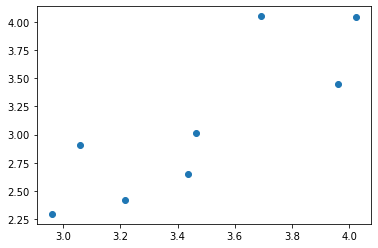

In [30]:
#subd = complete_data[(complete_data.species.isin(["Callithrix_jacchus","Homo_sapiens","Daubentonia_madagascariensis","Pongo_abelii","Saimiri_boliviensis","Nomascus_leucogenys","Macaca_mulatta","Microcebus_murinus"]))]
#x = np.log10(subd.GenerationLength_d)
#y = subd.alpha
#plt.scatter(x,y)
#stats.pearsonr(x,y)